In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

import nltk
import re
from nltk.corpus import stopwords

nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df=pd.read_csv('/kaggle/input/fake-news/train.csv')
df

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


## Total number of categorical columns


(array([1., 0., 0., 0., 0., 1., 0., 0., 0., 1.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

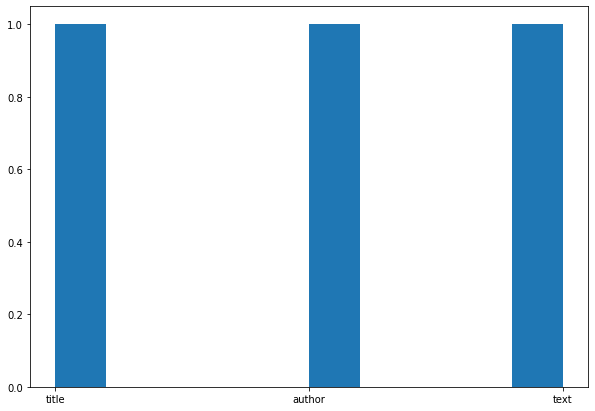

In [3]:
x=df.select_dtypes(object).columns.tolist()
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(x)

## Total number of Numerical columns


In [4]:
df.select_dtypes(int).columns.tolist()

['id', 'label']

## Total number of Missing columns


In [5]:
df

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'id'),
  Text(1, 0, 'title'),
  Text(2, 0, 'author'),
  Text(3, 0, 'text'),
  Text(4, 0, 'label')])

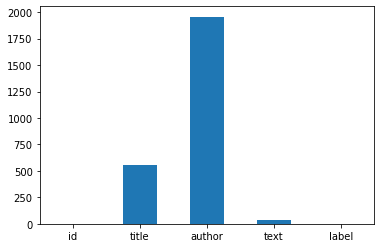

In [6]:
df.isna().sum().plot(kind='bar')
plt.xticks(rotation = 0)

## Drop NaN values

In [7]:
df=df.dropna()

# Checking Null values 

In [8]:
df.isna().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

# Checking shape of data set

In [9]:
df.shape

(18285, 5)

# Text length statistics

In [10]:
text_len=df.text.str.split().str.len()
print(text_len.describe())

count    18285.000000
mean       803.122942
std        886.230161
min          0.000000
25%        304.000000
50%        610.000000
75%       1092.000000
max      24234.000000
Name: text, dtype: float64


# Title length statistics

In [11]:
title_len=df.title.str.split().str.len()
print(title_len.describe())

count    18285.000000
mean        12.524255
std          4.023303
min          1.000000
25%         10.000000
50%         13.000000
75%         15.000000
max         72.000000
Name: title, dtype: float64


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

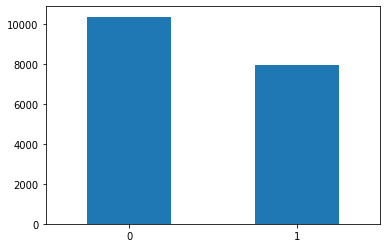

In [12]:
df.label.value_counts().plot(kind='bar')
plt.xticks(rotation=0)


# Get Independent Variables

In [13]:
X=df.drop('label',axis=1)

# Get Dependent Variables

In [14]:
y=df['label']


# Setting Vocabulary size

In [15]:
voc_size=5000

In [16]:
messages=X.copy()

In [17]:
messages['title'][1]

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'

In [18]:
messages.reset_index(inplace=True)

# Data Cleaning

In [19]:
from nltk.stem.porter import PorterStemmer
ps=PorterStemmer()
corpus=[]
for i in range(0,len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

Word Cloud Representations

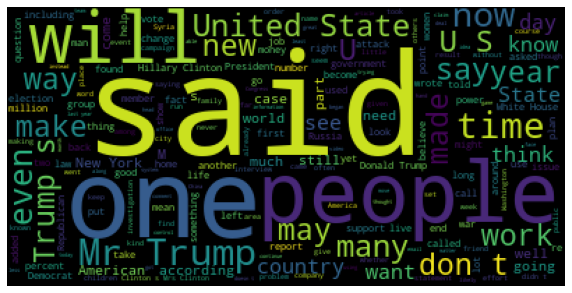

In [20]:
from wordcloud import WordCloud, STOPWORDS

# initialize the word cloud
wordcloud = WordCloud( background_color='black')
# generate the word cloud by passing the corpus
text_cloud = wordcloud.generate(' '.join(df['text']))
# plotting the word cloud
plt.figure(figsize=(10,20))
plt.imshow(text_cloud)
plt.axis('off')
plt.show()

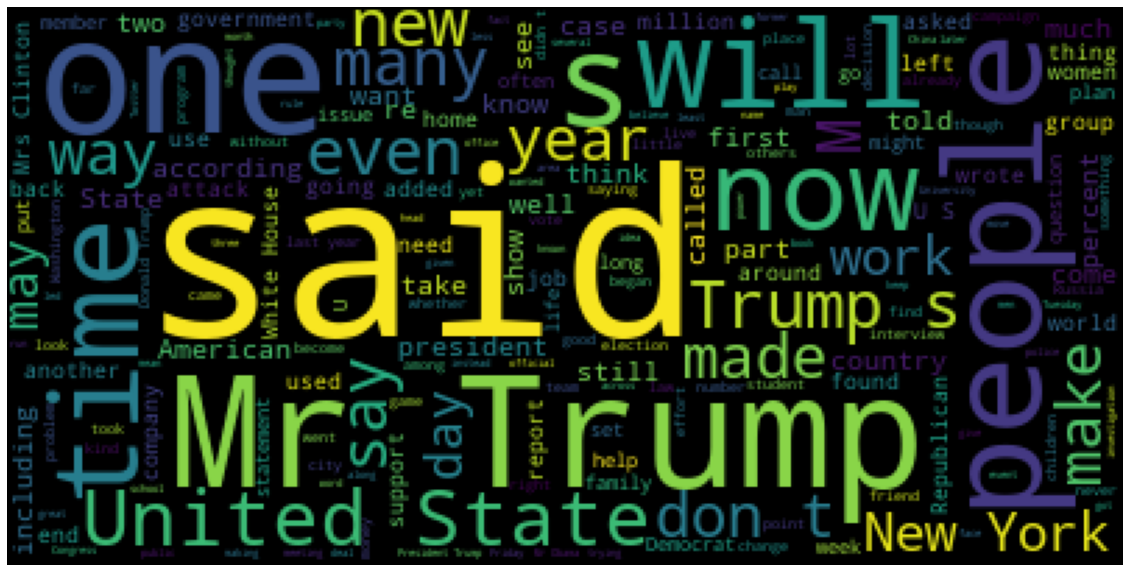

In [21]:
label_0 = ' '.join(df[df['label']==0]['text']) 
wc = wordcloud.generate(label_0)
plt.figure(figsize=(20,30))
plt.imshow(wc)
plt.axis('off')
plt.show()

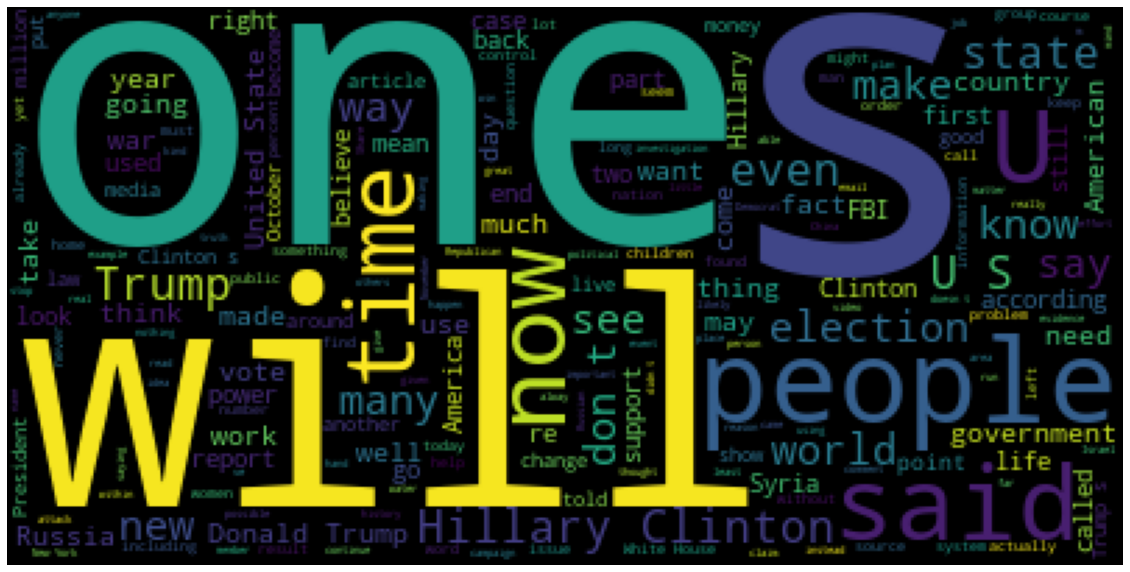

In [22]:
label_0 = ' '.join(df[df['label']==1]['text']) 
wc = wordcloud.generate(label_0)
plt.figure(figsize=(20,30))
plt.imshow(wc)
plt.axis('off')
plt.show()

# One Hot Representation of Corpus

In [23]:
one_hot_representation=[one_hot(words,voc_size)for words in corpus]
print(one_hot_representation)

[[856, 3738, 4197, 2468, 1571, 995, 4978, 4801, 4344, 1366], [3667, 333, 4501, 3476, 3981, 933, 3690], [2303, 3630, 745, 1889], [2948, 1721, 1548, 4760, 177, 465], [7, 3981, 2813, 3198, 230, 379, 3981, 4233, 2001, 3149], [995, 986, 4230, 4848, 2451, 1955, 4484, 3035, 3637, 4009, 4194, 3098, 4972, 123, 3690], [1096, 688, 834, 2784, 2428, 3952, 1560, 2027, 3716, 156, 650], [2092, 4204, 4224, 3054, 4096, 3751, 1955, 4198, 3716, 156, 650], [3451, 4339, 4013, 4532, 2013, 974, 172, 2087, 1955, 2658], [1436, 232, 3269, 1932, 4714, 2238, 3473, 958], [2137, 515, 2037, 3708, 988, 3752, 1159, 326, 3797, 3260, 2908], [4760, 2840, 1571, 974, 1955, 4096], [928, 3172, 4557, 4918, 2371, 2247, 1723, 4904, 3385], [4007, 480, 2469, 710, 1538, 953, 647, 3716, 156, 650], [4485, 4616, 3108, 3337, 1582, 3716, 156, 650], [3755, 3010, 1556, 569, 1131, 2650, 3151, 332, 4693, 1434], [1753, 1056, 333], [3021, 2823, 2644, 1764, 1955, 1602, 502, 3690], [2320, 3762, 4501, 1864, 4275, 4584, 816, 785, 379], [1303, 348

# Apply padding

In [24]:
sent_length=20
embedded_docs=pad_sequences(one_hot_representation,padding='post',maxlen=sent_length)
print(embedded_docs)

[[ 856 3738 4197 ...    0    0    0]
 [3667  333 4501 ...    0    0    0]
 [2303 3630  745 ...    0    0    0]
 ...
 [2779 2007 2862 ...    0    0    0]
 [4530 4096  215 ...    0    0    0]
 [ 235  519 4253 ...    0    0    0]]


# Modelling

In [25]:
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

2022-12-13 06:41:53.914141: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 40)            200000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
embedded_docs

array([[ 856, 3738, 4197, ...,    0,    0,    0],
       [3667,  333, 4501, ...,    0,    0,    0],
       [2303, 3630,  745, ...,    0,    0,    0],
       ...,
       [2779, 2007, 2862, ...,    0,    0,    0],
       [4530, 4096,  215, ...,    0,    0,    0],
       [ 235,  519, 4253, ...,    0,    0,    0]], dtype=int32)

In [27]:
y

0        1
1        0
2        1
3        1
4        1
        ..
20795    0
20796    0
20797    0
20798    1
20799    1
Name: label, Length: 18285, dtype: int64

In [28]:
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [29]:
X_final.shape,y_final.shape

((18285, 20), (18285,))

# Applying Early Stopping

In [30]:
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)


# Training the model

In [32]:
from keras.api._v2.keras import callbacks
model_histroy=model.fit(X_train,y_train,validation_split=0.33,batch_size=10,epochs=1000,callbacks=early_stopping)

2022-12-13 06:41:55.343254: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000
821/821 [==============================] - 22s 24ms/step - loss: 0.2590 - accuracy: 0.8907 - val_loss: 0.2208 - val_accuracy: 0.9132
Epoch 2/1000
821/821 [==============================] - 18s 22ms/step - loss: 0.1334 - accuracy: 0.9521 - val_loss: 0.2267 - val_accuracy: 0.8996
Epoch 3/1000
821/821 [==============================] - 19s 23ms/step - loss: 0.0754 - accuracy: 0.9751 - val_loss: 0.2323 - val_accuracy: 0.9204
Epoch 4/1000
821/821 [==============================] - 19s 23ms/step - loss: 0.0514 - accuracy: 0.9850 - val_loss: 0.3403 - val_accuracy: 0.9152
Epoch 5/1000
821/821 [==============================] - 18s 22ms/step - loss: 0.0335 - accuracy: 0.9901 - val_loss: 0.3004 - val_accuracy: 0.9149
Epoch 6/1000
821/821 [==============================] - 19s 23ms/step - loss: 0.0269 - accuracy: 0.9924 - val_loss: 0.3747 - val_accuracy: 0.9102
Epoch 7/1000
821/821 [==============================] - 18s 22ms/step - loss: 0.0235 - accuracy: 0.9939 - val_loss: 0.3623 -

## Plot accuracy vs val_accuracy

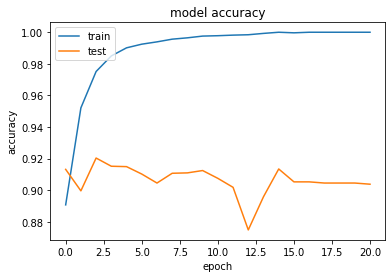

In [33]:
plt.plot(model_histroy.history['accuracy'])
plt.plot(model_histroy.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

# Plot loss vs val_accuracy

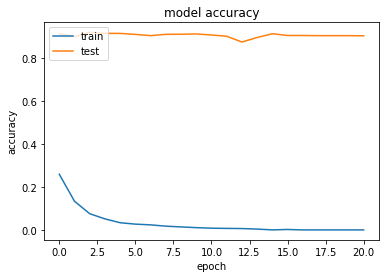

In [34]:
plt.plot(model_histroy.history['loss'])
plt.plot(model_histroy.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

In [35]:
y_preds=model.predict(X_test)
y_preds=(y_preds>=0.5)

# Confusion Matrix

In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_preds)

array([[3108,  311],
       [ 300, 2316]])

# Accuracy score

In [37]:
from sklearn.metrics import accuracy_score
score=accuracy_score(y_test,y_preds)
print(score)

0.8987572493786247


# Adding Dropout

In [38]:
from tensorflow.keras.layers import Dropout
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Training Model with Validation data

In [39]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=1000,batch_size=64,callbacks=early_stopping)

Epoch 1/1000
192/192 [==============================] - 9s 36ms/step - loss: 0.3287 - accuracy: 0.8367 - val_loss: 0.1968 - val_accuracy: 0.9145
Epoch 2/1000
192/192 [==============================] - 7s 35ms/step - loss: 0.1472 - accuracy: 0.9452 - val_loss: 0.1964 - val_accuracy: 0.9191
Epoch 3/1000
192/192 [==============================] - 6s 31ms/step - loss: 0.1076 - accuracy: 0.9617 - val_loss: 0.2352 - val_accuracy: 0.9176
Epoch 4/1000
192/192 [==============================] - 6s 31ms/step - loss: 0.0827 - accuracy: 0.9706 - val_loss: 0.2709 - val_accuracy: 0.9168
Epoch 5/1000
192/192 [==============================] - 6s 32ms/step - loss: 0.0599 - accuracy: 0.9794 - val_loss: 0.2552 - val_accuracy: 0.9128
Epoch 6/1000
192/192 [==============================] - 6s 32ms/step - loss: 0.0452 - accuracy: 0.9847 - val_loss: 0.3428 - val_accuracy: 0.9127
Epoch 7/1000
192/192 [==============================] - 7s 35ms/step - loss: 0.0424 - accuracy: 0.9869 - val_loss: 0.3345 - val_ac

In [40]:
model_histroy.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

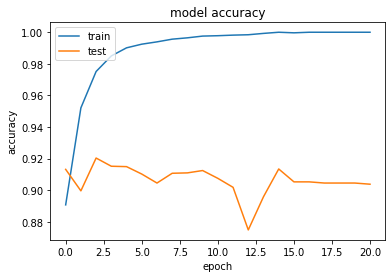

In [41]:
plt.plot(model_histroy.history['accuracy'])
plt.plot(model_histroy.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

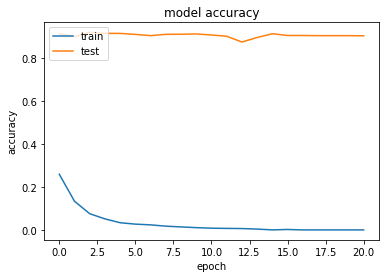

In [42]:
plt.plot(model_histroy.history['loss'])
plt.plot(model_histroy.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

In [43]:
y_preds=model.predict(X_test)
y_preds=(y_preds>=0.5) # Whenever value>=0.5 it takes 1 else 0

In [44]:
# Make the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_preds)

array([[3117,  302],
       [ 263, 2353]])

In [45]:
from sklearn.metrics import accuracy_score
score=accuracy_score(y_test,y_preds)
print(score)

0.9063794531897266
